# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(680887, 27)


,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
1,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0.71,-0.71,2.62,0,-0.027,108.0,75.3,75.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0.04,-0.04,2.46,0,-0.020,157.0,83.5,65.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
3,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,1.53,6.83,5.9,54.61,-2.10,2.10,3.89,0,0.016,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0


Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data[['velo', 'pfx_-x', 'pfx_z', 'release_extension',
                 'delta_run_exp', 'plate_x', 'plate_z', 'pitch_type']]
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(8)

,feature,VIF
4,delta_run_exp,1.000032
5,plate_x,1.087051
1,pfx_-x,1.127049
2,pfx_z,2.713967
6,plate_z,7.608490
3,release_extension,148.529519
0,velo,169.201899


# Features

In [4]:
ff = features.loc[features['pitch_type'] == 'FF']
print('4-seam shape:', ff.shape)
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)

4-seam shape: (249672, 8)
Cutter shape: (47442, 8)
Sinker shape: (109145, 8)
Slider shape: (135539, 8)
Curveball shape: (58767, 8)
Changeup shape: (80322, 8)


# Clustering 

## 4-Seam Fastball

In [5]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca_ff = PCA().fit_transform(X_ff_scaled)
model_ff = pd.DataFrame(data = pca_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print('Predicted clusters to points: ', label_ff[:10], '\n')

Number of iterations: 8
Number of features: 7
Number of clusters: 2
Inertia: 1522720.2802527964 

Predicted clusters to points:  [1 1 1 1 0 0 0 0 0 0] 



### Cluster Labels - 4-Seam

In [6]:
# 0 good, 1 bad

X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
velo,94.668695,92.097514
pfx_-x,7.404620,-4.723074
pfx_z,16.410703,15.589946
release_extension,6.456595,6.220052
delta_run_exp,-0.002847,0.005836
plate_x,0.057094,-0.089664
plate_z,2.710272,2.798307


### Heatmaps of Features - 4-Seam

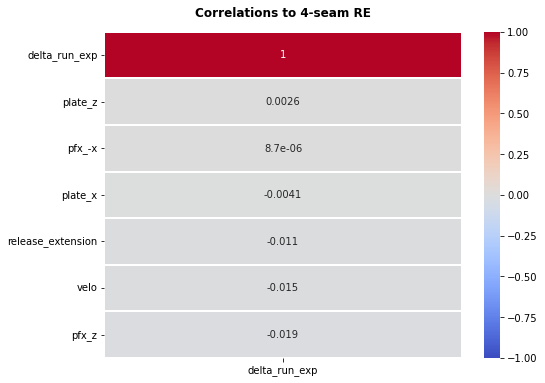

In [7]:
plt.figure(figsize = (8, 6))
sns.heatmap(ff.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam RE', fontweight = 'bold', pad = 15);

Positively correlated with label, as the positive values increase the run exp increases

Negatively correlated with lablel, as the negative values increase the run exp decreases and vice versa

Positively correlated with label, as the positive values increase the label increases

Negatively correlated with lablel, as the negative values increase the label decreases and vice versa

## Cutter

In [8]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca_fc = PCA().fit(X_fc_scaled)
principal_components_fc = pca_fc.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 14
Number of features: 7
Number of clusters: 2
Inertia: 284208.7347328636 

Predicted clusters to points:  [1 1 1 1 0 1 0 0 0 0] 



### Cluster Labels - Cutter

In [9]:
# 0 bad, 1 good

X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
velo,87.230184,89.600624
pfx_-x,1.233145,-3.546748
pfx_z,7.922785,7.924764
release_extension,6.132426,6.366805
delta_run_exp,0.010396,-0.009560
plate_x,-0.395194,0.618044
plate_z,2.578246,2.119142


### Heatmap of Features - Cutter

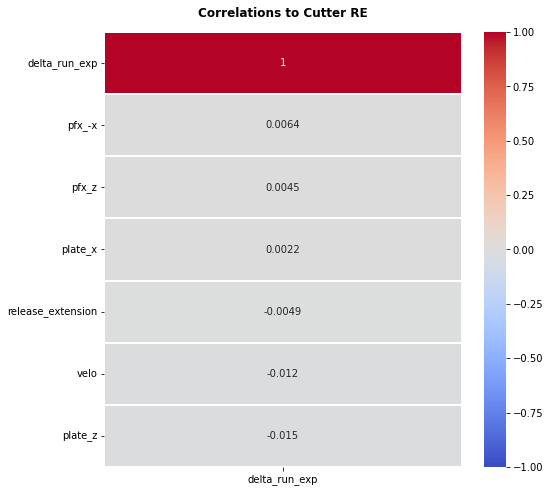

In [10]:
plt.figure(figsize = (8, 8))
sns.heatmap(fc.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter RE', fontweight = 'bold', pad = 15);

# Sinker

In [11]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 20
Number of features: 7
Number of clusters: 2
Inertia: 649242.0947829476 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Sinker

In [12]:
# 0 bad, 1 good

X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
velo,93.429217,92.062002
pfx_-x,14.789142,-14.798367
pfx_z,9.205533,9.285202
release_extension,6.317003,6.285028
delta_run_exp,0.000776,0.000175
plate_x,-0.205717,0.213062
plate_z,2.330197,2.346421


### Heatmap of Features - Sinker

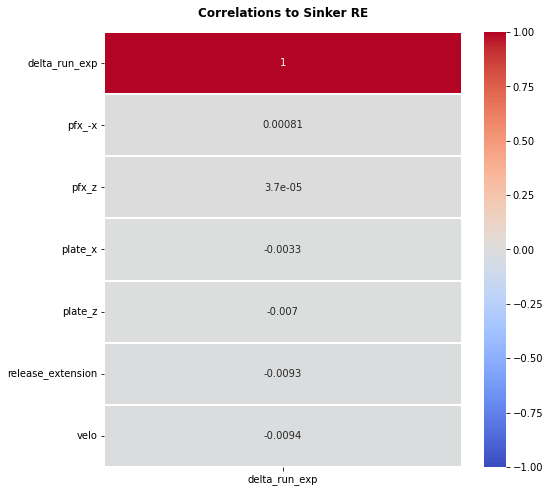

In [13]:
plt.figure(figsize = (8, 8))
sns.heatmap(si.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Sinker RE', fontweight = 'bold', pad = 15);

## Slider

In [14]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 15
Number of features: 7
Number of clusters: 2
Inertia: 824542.0718614865 

Predicted clusters to points:  [1 1 1 0 1 0 1 1 0 0] 



### Cluster Labels - Slider

In [15]:
# 0 good, 1 bad

X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
velo,84.974479,84.342382
pfx_-x,-7.063458,0.467510
pfx_z,1.481669,1.917169
release_extension,6.381503,6.139970
delta_run_exp,-0.014189,0.008393
plate_x,0.846613,-0.357306
plate_z,1.517804,2.238417


### Heatmap of Features - Slider

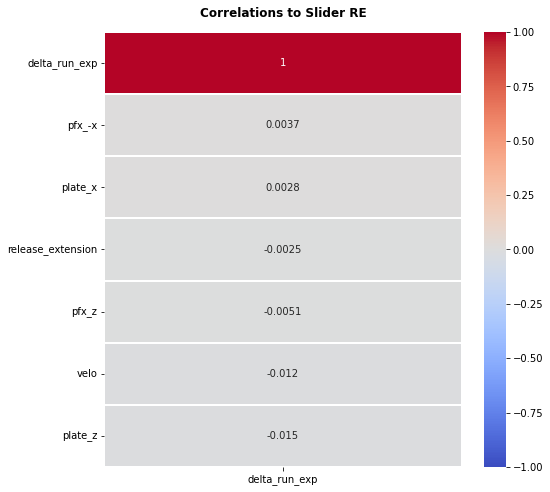

In [16]:
plt.figure(figsize = (8, 8))
sns.heatmap(sl.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider RE', fontweight = 'bold', pad = 15);

# Curveball

In [17]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 14
Number of features: 7
Number of clusters: 2
Inertia: 355075.6370701384 

Predicted clusters to points:  [1 1 1 0 0 0 0 0 0 0] 



### Cluster Labels - Curveball

In [18]:
# 0 good, 1 bad

X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
velo,80.122253,77.417103
pfx_-x,-9.086818,1.171457
pfx_z,-9.043448,-8.448690
release_extension,6.384887,6.037748
delta_run_exp,-0.013432,0.014690
plate_x,0.500545,-0.347718
plate_z,1.381962,2.268035


### Heatmaps of Features - Curveball

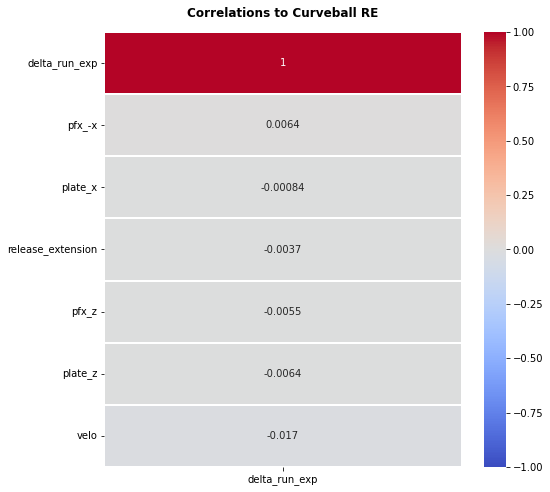

In [19]:
plt.figure(figsize = (8, 8))
sns.heatmap(cu.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Curveball RE', fontweight = 'bold', pad = 15);

## Changeup

In [20]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch)
principal_components_ch = pca.transform(X_ch)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 3
Number of features: 7
Number of clusters: 2
Inertia: 3883198.0847053807 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Changeup

In [21]:
# 0 good, 1 bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
velo,85.531494,83.573328
pfx_-x,13.864524,-13.891458
pfx_z,6.279576,7.763038
release_extension,6.343137,6.245232
delta_run_exp,0.002985,0.003150
plate_x,-0.349740,0.486184
plate_z,1.838259,1.870819


### Heatmap of Features - Changeup

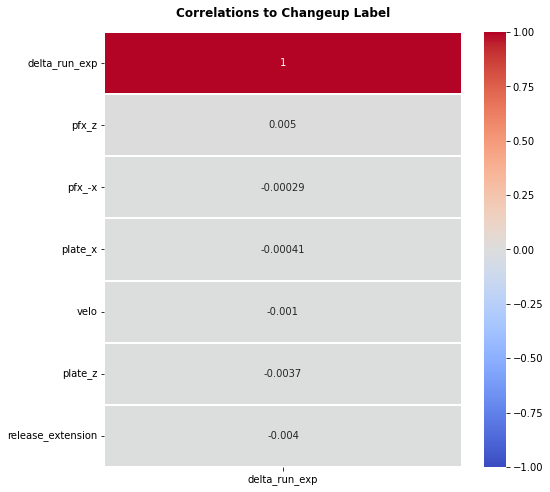

In [22]:
plt.figure(figsize = (8, 8))
sns.heatmap(ch.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

# Modeling

## Linear Regression - 4-Seam

In [23]:
X = X_ff.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff['delta_run_exp']

ols_ff = sm.OLS(y, X)
ols_ff = ols_ff.fit()
pred_ff = ols_ff.predict(X)
fitted_vals_ff = ols_ff.fittedvalues
residuals_ff = ols_ff.resid
norm_residuals_ff = ols_ff.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_ff = np.sqrt(np.abs(norm_residuals_ff))

ols_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     33.21
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           1.55e-46
Time:                        16:25:09   Log-Likelihood:                 1612.9
No. Observations:              249672   AIC:                            -3210.
Df Residuals:                  249664   BIC:                            -3126.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0465      0.023      2.006      0.045       0.001       0.092
velo                 -0.0002      0.000     -1.106      0.269      -0.001       0.000
pfx_-x                0.0008   9.95e-05      7.765      0.000       0.001       0.001
pfx_z                -0.0011      0.000     -7.041      0.000      -0.001      -0.001
release_extension    -0.0023      0.001     -2.006      0.045      -0.005   -5.31e-05
plate_x              -0.0001      0.001     -0.188      0.851      -0.001       0.001
plate_z               0.0002      0.001      0.349      0.727      -0.001       0.001
label                 0.0160      0.002      8.687      0.000       0.012       0.020
==============================================================================
Omnibus:                   204826.123   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8686660.041
Skew:                           3.692   Prob(JB):                         0.00
Kurtosis:                      30.937   Cond. No.                     4.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

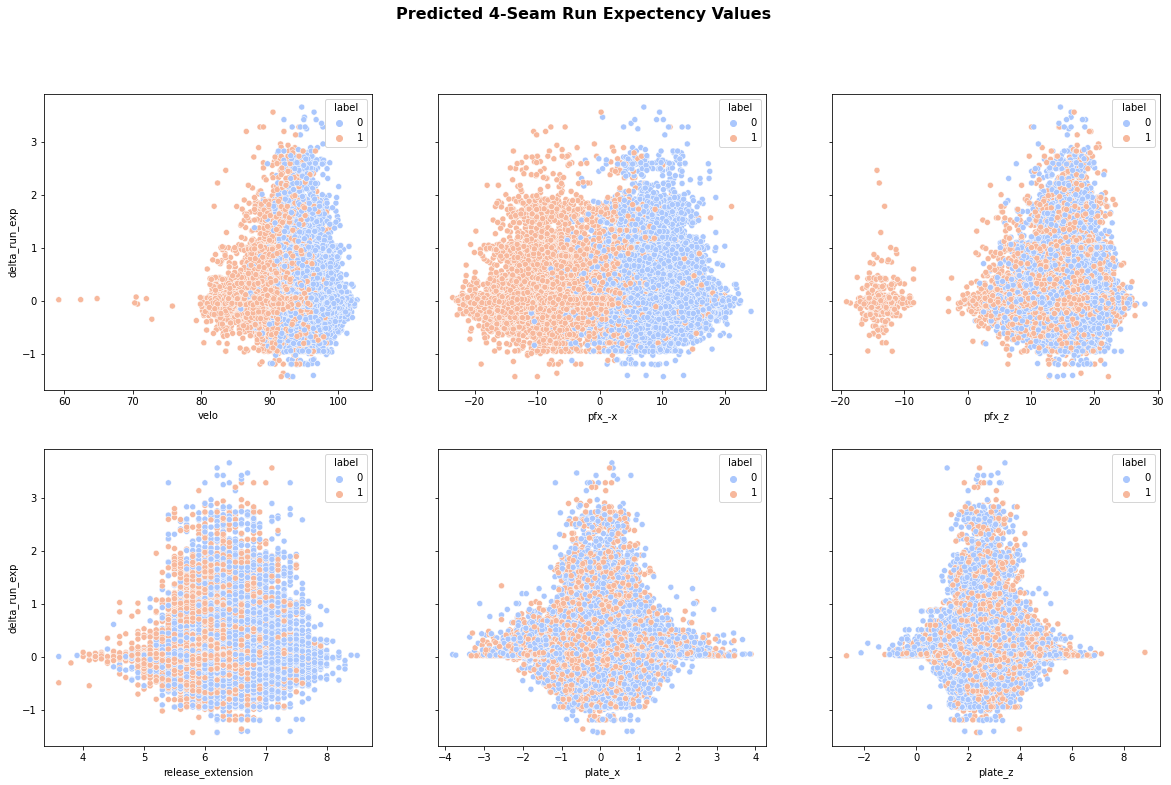

In [26]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12), sharey = True)
fig.suptitle('Predicted 4-Seam Run Expectency Values', fontsize = 16, fontweight = 'bold')
sns.scatterplot(ax=axs[0][0],data=X_ff,x='velo',y='delta_run_exp',hue='label',palette='coolwarm')
#axs[0][0].set_title('', fontsize = 14, pad = 15)
sns.scatterplot(ax=axs[0][1], data = X_ff, x = 'pfx_-x', y = 'delta_run_exp', hue = 'label', palette = 'coolwarm')
#axs[0][1].set_title('', fontsize = 14, pad = 15)
sns.scatterplot(ax = axs[0][2],data=X_ff,x='pfx_z',y='delta_run_exp',hue='label',palette='coolwarm')
#axs[0][2].set_title('', fontsize = 14, pad = 15)
sns.scatterplot(ax = axs[1][0],data=X_ff,x='release_extension',y='delta_run_exp',hue='label',palette='coolwarm')
#axs[1][0].set_title('', fontsize = 14, pad = 15)
sns.scatterplot(ax = axs[1][1],data=X_ff,x='plate_x',y='delta_run_exp',hue='label',palette='coolwarm')
#axs[1][1].set_title('', fontsize = 14, pad = 15)
sns.scatterplot(ax = axs[1][2],data=X_ff,x='plate_z',y='delta_run_exp',hue='label',palette='coolwarm');
#axs[1][2].set_title('', fontsize = 14, pad = 15);

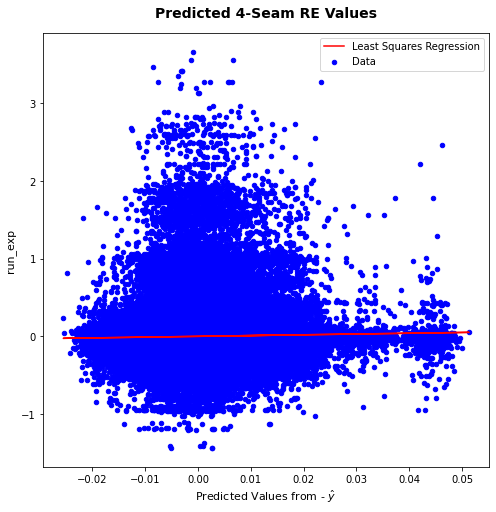

MSE: 0.0578
RMSE: 0.2404
MAE: 0.1206


In [27]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_ff, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff, np.poly1d(np.polyfit(pred_ff, y, 1))(pred_ff), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))

<Figure size 576x432 with 0 Axes>

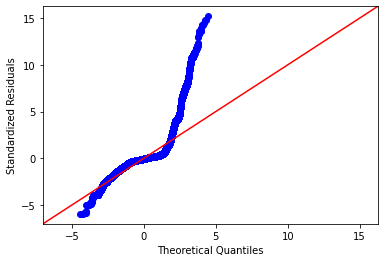

In [28]:
plt.figure(figsize = (8, 6))
sm.qqplot(residuals_ff, line = '45', fit = True);
plt.ylabel("Standardized Residuals");

In [29]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_ff, x = fitted_vals_ff, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [30]:
#sns.regplot(fitted_vals_ff, norm_residuals_abs_sqrt_ff,
#                     lowess=True,
#                     line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");

## Linear Regression - Cutter

In [31]:
X = X_fc.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc['delta_run_exp']

ols_fc = sm.OLS(y, X)
ols_fc = ols_fc.fit()
pred_fc = ols_fc.predict(X)
fitted_vals_fc = ols_fc.fittedvalues
residuals_fc = ols_fc.resid
norm_residuals_fc = ols_fc.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_fc = np.sqrt(np.abs(norm_residuals_fc))
ols_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     30.80
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           7.21e-43
Time:                        16:29:10   Log-Likelihood:                -2090.8
No. Observations:               47442   AIC:                             4198.
Df Residuals:                   47434   BIC:                             4268.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0760      0.042     -1.795      0.073      -0.159       0.007
velo                  0.0007      0.000      1.608      0.108      -0.000       0.001
pfx_-x               -0.0029      0.000     -7.246      0.000      -0.004      -0.002
pfx_z                 0.0006      0.000      1.978      0.048    5.85e-06       0.001
release_extension     0.0096      0.003      2.901      0.004       0.003       0.016
plate_x               0.0139      0.002      8.075      0.000       0.011       0.017
plate_z              -0.0100      0.001     -7.172      0.000      -0.013      -0.007
label                -0.0561      0.004    -13.736      0.000      -0.064      -0.048
==============================================================================
Omnibus:                    37915.689   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1453909.255
Skew:                           3.575   Prob(JB):                         0.00
Kurtosis:                      29.161   Cond. No.                     3.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

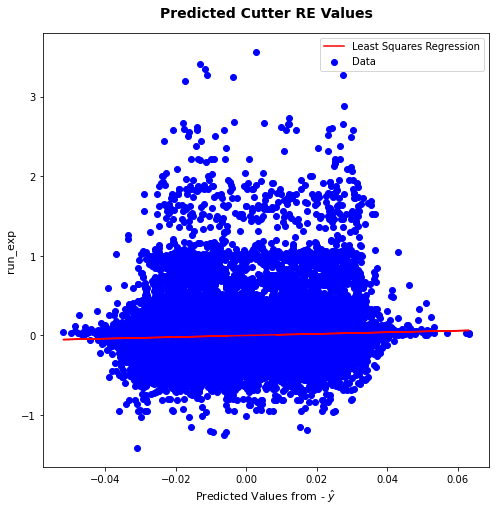

MSE: 0.0639
RMSE: 0.2529
MAE: 0.128


In [32]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_fc, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc, np.poly1d(np.polyfit(pred_fc, y, 1))(pred_fc), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_fc), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc), 4))

Text(0, 0.5, 'Standardized Residuals')

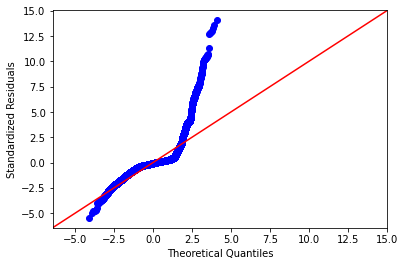

In [33]:
sm.qqplot(residuals_fc, line = '45', fit = True)
plt.ylabel("Standardized Residuals")

In [34]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_fc, x = fitted_vals_fc, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [35]:
#sns.regplot(fitted_vals_fc, norm_residuals_abs_sqrt_fc,
#                     lowess=True,
#                     line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");

## Linear Regression - Sinker

In [36]:
X = X_si.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si['delta_run_exp']

ols_si = sm.OLS(y, X)
ols_si = ols_si.fit()
pred_si = ols_si.predict(X)
fitted_vals_si = ols_si.fittedvalues
residuals_si = ols_si.resid
norm_residuals_si = ols_si.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_si = np.sqrt(np.abs(norm_residuals_si))

ols_si.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.225
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           0.000114
Time:                        16:29:10   Log-Likelihood:                -5088.6
No. Observations:              109145   AIC:                         1.019e+04
Df Residuals:                  109137   BIC:                         1.027e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1267      0.027      4.609      0.000       0.073       0.181
velo                 -0.0009      0.000     -3.370      0.001      -0.001      -0.000
pfx_-x               -0.0002      0.000     -0.607      0.544      -0.001       0.000
pfx_z                 0.0003      0.000      1.549      0.121   -6.98e-05       0.001
release_extension    -0.0056      0.002     -3.196      0.001      -0.009      -0.002
plate_x              -0.0014      0.001     -1.417      0.156      -0.003       0.001
plate_z              -0.0026      0.001     -2.695      0.007      -0.005      -0.001
label                -0.0059      0.008     -0.782      0.434      -0.021       0.009
==============================================================================
Omnibus:                    76053.890   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2095985.814
Skew:                           3.007   Prob(JB):                         0.00
Kurtosis:                      23.609   Cond. No.                     3.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

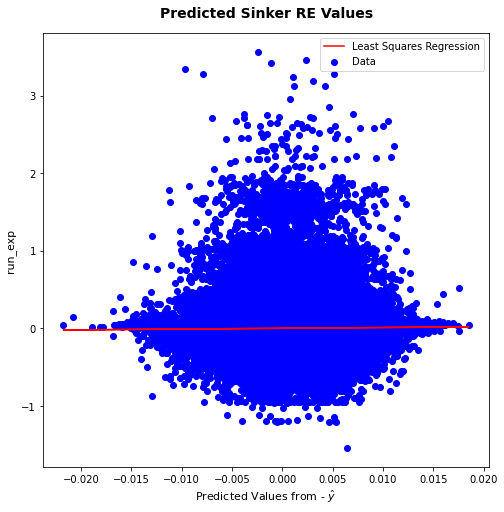

MSE: 0.0643
RMSE: 0.2535
MAE: 0.1347


In [37]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_si, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si, np.poly1d(np.polyfit(pred_si, y, 1))(pred_si), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))

Text(0, 0.5, 'Standardized Residuals')

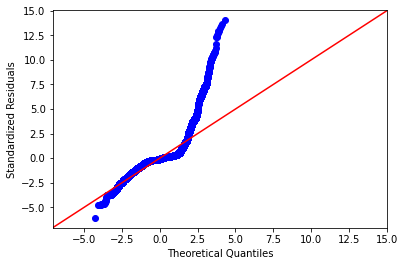

In [38]:
sm.qqplot(residuals_si, line = '45', fit = True)
plt.ylabel("Standardized Residuals")

In [39]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_si, x = fitted_vals_si, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [40]:
#sns.regplot(fitted_vals_si, norm_residuals_abs_sqrt_si,
#                     lowess=True,
#                     line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");

## Linear Regression - Slider

In [41]:
X = X_sl.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl['delta_run_exp']

ols_sl = sm.OLS(y, X)
ols_sl = ols_sl.fit()
pred_sl = ols_sl.predict(X)
fitted_vals_sl = ols_sl.fittedvalues
residuals_sl = ols_sl.resid
norm_residuals_sl = ols_sl.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_sl = np.sqrt(np.abs(norm_residuals_sl))
ols_sl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     142.3
Date:                Mon, 28 Feb 2022   Prob (F-statistic):          4.80e-210
Time:                        16:29:11   Log-Likelihood:                -2420.4
No. Observations:              135539   AIC:                             4857.
Df Residuals:                  135531   BIC:                             4935.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0482      0.020     -2.437      0.015      -0.087      -0.009
velo                 -0.0004      0.000     -2.080      0.038      -0.001   -2.39e-05
pfx_-x               -0.0015      0.000    -13.656      0.000      -0.002      -0.001
pfx_z                -0.0003      0.000     -1.690      0.091      -0.001     4.2e-05
release_extension     0.0102      0.002      6.637      0.000       0.007       0.013
plate_x               0.0188      0.001     19.071      0.000       0.017       0.021
plate_z              -0.0145      0.001    -17.618      0.000      -0.016      -0.013
label                 0.0694      0.002     30.579      0.000       0.065       0.074
==============================================================================
Omnibus:                   112719.724   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4767151.428
Skew:                           3.775   Prob(JB):                         0.00
Kurtosis:                      31.056   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

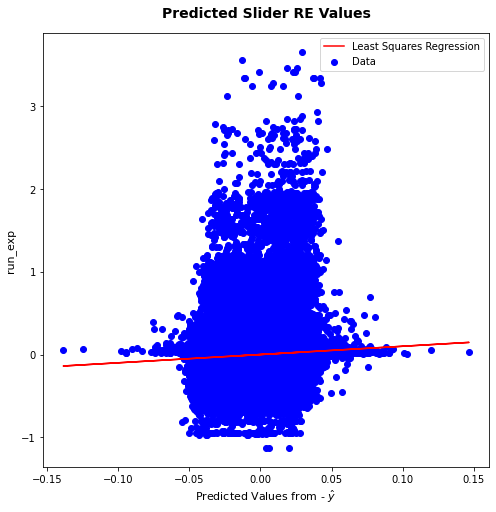

MSE: 0.0607
RMSE: 0.2463
MAE: 0.1241


In [42]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_sl, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl, np.poly1d(np.polyfit(pred_sl, y, 1))(pred_sl), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_sl), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl), 4))

Text(0, 0.5, 'Standardized Residuals')

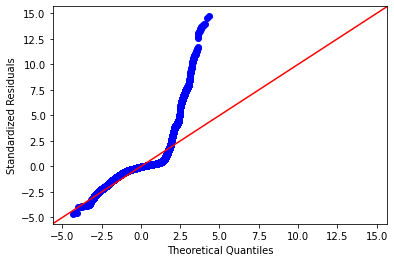

In [43]:
sm.qqplot(residuals_sl, line = '45', fit = True)
plt.ylabel("Standardized Residuals")

In [44]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_sl, x = fitted_vals_sl, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [45]:
#sns.regplot(fitted_vals_sl, norm_residuals_abs_sqrt_sl,
#                     lowess=True,
#                     line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");

## Linear Regression - Curveball

In [46]:
X = X_cu.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu['delta_run_exp']

ols_cu = sm.OLS(y, X)
ols_cu = ols_cu.fit()
pred_cu = ols_cu.predict(X)
fitted_vals_cu = ols_cu.fittedvalues
residuals_cu = ols_cu.resid
norm_residuals_cu = ols_cu.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_cu = np.sqrt(np.abs(norm_residuals_cu))
ols_cu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     84.52
Date:                Mon, 28 Feb 2022   Prob (F-statistic):          6.52e-123
Time:                        16:29:12   Log-Likelihood:                 5045.0
No. Observations:               58767   AIC:                        -1.007e+04
Df Residuals:                   58759   BIC:                        -1.000e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2627      0.029     -9.063      0.000      -0.319      -0.206
velo                  0.0012      0.000      4.525      0.000       0.001       0.002
pfx_-x               -0.0013      0.000    -11.885      0.000      -0.002      -0.001
pfx_z                -0.0003      0.000     -1.532      0.126      -0.001    7.04e-05
release_extension     0.0229      0.002      9.423      0.000       0.018       0.028
plate_x               0.0137      0.001     11.227      0.000       0.011       0.016
plate_z              -0.0111      0.001    -11.400      0.000      -0.013      -0.009
label                 0.0747      0.003     23.833      0.000       0.069       0.081
==============================================================================
Omnibus:                    52821.316   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3011828.567
Skew:                           4.159   Prob(JB):                         0.00
Kurtosis:                      37.071   Cond. No.                     2.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

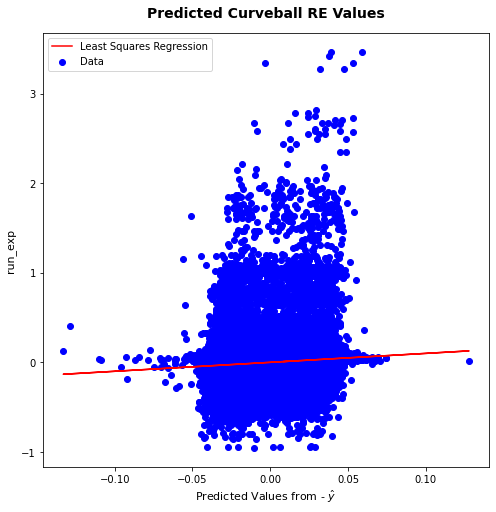

MSE: 0.0493
RMSE: 0.2221
MAE: 0.1084


In [47]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_cu, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu, np.poly1d(np.polyfit(pred_cu, y, 1))(pred_cu), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_cu), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu), 4))

Text(0, 0.5, 'Standardized Residuals')

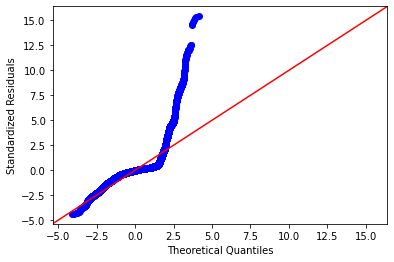

In [48]:
sm.qqplot(residuals_cu, line='45', fit=True)
plt.ylabel("Standardized Residuals")

In [49]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_cu, x = fitted_vals_cu, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [50]:
#sns.regplot(fitted_vals_cu, norm_residuals_abs_sqrt_cu,
#                     lowess=True,
#                     line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");

## Linear Regression - Changeup

In [51]:
X = X_ch.drop(columns = ['delta_run_exp', 'label'])
X = sm.add_constant(X)
y = X_ch['delta_run_exp']

ols_ch = sm.OLS(y, X).fit()
pred_ch = ols_ch.predict(X)
fitted_vals_ch = ols_ch.fittedvalues
residuals_ch = ols_ch.resid
norm_residuals_ch = ols_ch.get_influence().resid_studentized_internal
norm_residuals_abs_sqrt_ch = np.sqrt(np.abs(norm_residuals_ch))
print(ols_ch.summary())

                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9162
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.482
Time:                        16:29:13   Log-Likelihood:                -3132.9
No. Observations:               80322   AIC:                             6280.
Df Residuals:                   80315   BIC:                             6345.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0263      0.02

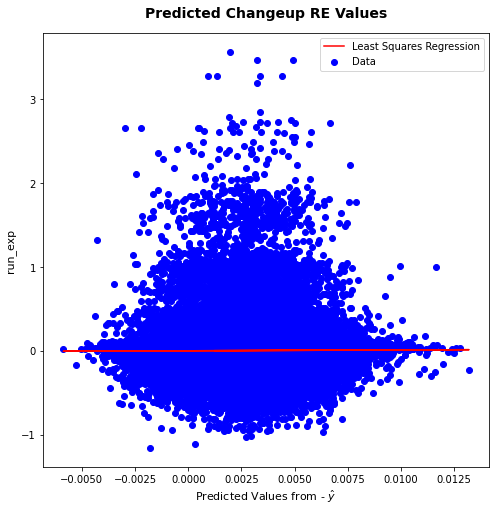

MSE: 0.0633
RMSE: 0.2516
MAE: 0.1302


In [52]:
plt.figure(figsize = (8, 8))
plt.scatter(pred_ch, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch, np.poly1d(np.polyfit(pred_ch, y, 1))(pred_ch), c = 'r', label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ch), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch), 4))

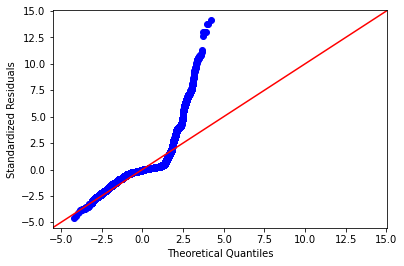

In [53]:
sm.qqplot(residuals_ch, line = '45', fit = True)
plt.ylabel('Standardized Residuals');

In [54]:
#plt.figure(figsize = (8, 8))
#
#sns.residplot(data = X_ch, x = fitted_vals_ch, y = 'delta_run_exp', lowess = True, line_kws = {"color": "red"})
##plt.xlabel('Fitted Values', fontsize = 11), plt.ylabel('Residuals', fontsize = 11)
#plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

In [55]:
#sns.regplot(fitted_vals_ch, norm_residuals_abs_sqrt_ch, lowess=True, line_kws={"color" : "red"})
#plt.xlabel("Fitted values")
#plt.ylabel("Sqrt of |Standardized Residuals|");